## Set up libraries etc

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import os
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Read your credentials for accessing the COVID database from a file
* In general, personal credentials should never be included in a code file that you will share

## Read the data

In [2]:
person_data = pd.read_csv("data_covid.csv")
person_data

,person_id,cov_dt,category,race_name,gen_name,current_age,measurement_name,measurement_date,value_as_number,unit_name
0,68,2020-03-14,mild,White,MALE,72.0,Body temperature,2020-03-14,41.0,degree Celsius
1,68,2020-03-14,mild,White,MALE,72.0,Diastolic blood pressure,2020-03-14,76.0,millimeter mercury column
2,68,2020-03-14,mild,White,MALE,72.0,Heart rate,2020-03-14,139.8,per minute
3,68,2020-03-14,mild,White,MALE,72.0,Body weight,2020-03-14,86.1,kilogram
4,68,2020-03-14,mild,White,MALE,72.0,Systolic blood pressure,2020-03-14,135.0,millimeter mercury column
...,...,...,...,...,...,...,...,...,...,...
219917,124140,2020-03-16,moderate,White,FEMALE,65.0,Body weight,2020-03-21,65.9,kilogram
219918,124140,2020-03-16,moderate,White,FEMALE,65.0,Systolic blood pressure,2020-03-21,119.0,millimeter mercury column
219919,124140,2020-03-16,moderate,White,FEMALE,65.0,Oxygen saturation in Arterial blood,2020-03-21,76.9,percent
219920,124140,2020-03-16,moderate,White,FEMALE,65.0,Respiratory rate,2020-03-21,27.2,per minute


## How many patients?

In [3]:
print(f"Number of patients = {person_data['person_id'].nunique()}")
print(f"Number of patients with mild covid = {person_data[person_data['category'] == 'mild']['person_id'].nunique()}")
print(f"Number of patients with moderate covid = {person_data[person_data['category'] == 'moderate']['person_id'].nunique()}")
print(f"Number of patients with severe covid = {person_data[person_data['category'] == 'severe']['person_id'].nunique()}")

Number of patients = 1763
Number of patients with mild covid = 1003
Number of patients with moderate covid = 541
Number of patients with severe covid = 219


## How many unique categories are there?

In [4]:
uniq_cats = person_data['category'].unique()
print(f"Number of unique categories = {person_data['category'].unique()}")
print(uniq_cats)

Number of unique categories = ['mild' 'moderate' 'severe']
['mild' 'moderate' 'severe']


## How many measurements are there in each of the categories?

In [5]:
mild_count = len(person_data[person_data['category'] == 'mild'])
print(f"Number of records with mild COVID is {mild_count}")

moderate_count = len(person_data[person_data['category'] == 'moderate'])
print(f"Number of records with moderate COVID is {moderate_count}")  

severe_count = len(person_data[person_data['category'] == 'severe'])
print(f"Number of records with severe COVID is {severe_count}") 

total_count = len(person_data)
print(f"Number of records with severe COVID is {total_count}") 

Number of records with mild COVID is 7430
Number of records with moderate COVID is 139518
Number of records with severe COVID is 72974
Number of records with severe COVID is 219922


## How many unique types of labs/vitals?

In [6]:
labs_vitals = person_data['measurement_name'].unique()
print(f"Number of Labs and Vitals = {len(labs_vitals)}")
print(labs_vitals)

Number of Labs and Vitals = 22
['Body temperature' 'Diastolic blood pressure' 'Heart rate' 'Body weight'
 'Systolic blood pressure' 'Oxygen saturation in Arterial blood'
 'Respiratory rate' 'Erythrocytes [#/volume] in Blood by Automated count'
 'Hemoglobin [Mass/volume] in Blood'
 'Hematocrit [Volume Fraction] of Blood by Automated count'
 'MCHC [Mass/volume] by Automated count'
 'Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (MDRD)'
 'Protein [Mass/volume] in Serum or Plasma'
 'Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma'
 'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma'
 'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma'
 'Leukocytes [#/volume] in Blood by Automated count'
 'MCV [Entitic volume] by Automated count'
 'MCH [Entitic mass] by Automated count'
 'Platelets [#/volume] in Blood by Automated count'
 'Albumin [Mass/volume] in Serum

## Create a summary table

In [7]:
# Create a summary table of the patients
# Select demographic information of patients
person_demog = person_data[['person_id', 'category', 'race_name', 'gen_name', 'current_age']].drop_duplicates()
# Create bins for the age
bins=[0, 18, 46, 66, np.inf]
labels=['<18', '18-45', '46-65', '>65']
person_demog['age_group'] = pd.cut(person_demog['current_age'], bins=bins, labels=labels, right=False)
person_demog
# Count patients by category
person_demog_count_by_category = person_demog.groupby('category').size()
person_demog_count_by_category_format = person_demog_count_by_category.apply(lambda x: f"n={x:,}") #format the values
person_demog_count_by_category_format
# Create column headers
column_headers = list(map(lambda x: str.capitalize(x[0])+' COVID\nn='+f"{x[1]:,}",zip(person_demog_count_by_category.index.values,person_demog_count_by_category.values)))
# Count patients by category and sex
person_demog_count_by_category_sex = person_demog.groupby(['category', 'gen_name']).size()
person_demog_count_by_category_sex_percent = (person_demog_count_by_category_sex/person_demog_count_by_category) 
s1 = pd.Series(map(lambda x:f"{x[0]:,}({x[1]*100:.0f}%)", zip(person_demog_count_by_category_sex, person_demog_count_by_category_sex_percent)), index=person_demog_count_by_category_sex.index)  
# Count patients by category and age
person_demog_count_by_category_age = person_demog.groupby(['category', 'age_group']).size().rename("Count_by_cat_age")
person_demog_count_by_category_age_percent = (person_demog_count_by_category_age/person_demog_count_by_category).rename("Percent_by_cat_age")
s2 = pd.Series(map(lambda x:f"{x[0]:,}({x[1]*100:.0f}%)", zip(person_demog_count_by_category_age, person_demog_count_by_category_age_percent)), index=person_demog_count_by_category_age.index)  
# Count patients by category and race
person_demog_count_by_category_race = person_demog.groupby(['category', 'race_name']).size().rename("Count_by_cat_race")
person_demog_count_by_category_race_percent = (person_demog_count_by_category_race/person_demog_count_by_category).rename("Percent_by_cat_race")
s3 = pd.Series(map(lambda x:f"{x[0]:,}({x[1]*100:.0f}%)", zip(person_demog_count_by_category_race, person_demog_count_by_category_race_percent)), index=person_demog_count_by_category_race.index)
# Convert the categories as column and create multiindex
df1, df2, df3 = s1.unstack(level=0), s2.unstack(level=0), s3.unstack(level=0)
df1.index.name, df2.index.name, df3.index.name  = 'sex', 'age', 'race' 
df1.index = pd.MultiIndex.from_tuples([(df1.index.name,str.lower(i)) for i in df1.index.values])
df2.index = pd.MultiIndex.from_tuples([(df2.index.name,str.lower(i)) for i in df2.index.values])
df3.index = pd.MultiIndex.from_tuples([(df3.index.name,str.lower(i)) for i in df3.index.values])
# Combine all
full_table = pd.concat([df1, df2, df3])
# Change the columns to Multiindex
full_table.columns = pd.MultiIndex.from_tuples([tuple(i.split('\n')) for i in column_headers])
# Display the summary table
display(full_table)

Mild COVID Moderate COVID Severe COVID
                                  n=1,003          n=541        n=219
sex  female                      518(52%)       299(55%)      92(42%)
     male                        485(48%)       242(45%)     127(58%)
age  <18                         186(19%)         35(6%)        2(1%)
     18-45                       403(40%)       159(29%)       14(6%)
     46-65                       234(23%)       204(38%)      62(28%)
     >65                         180(18%)       143(26%)     141(64%)
race asian                         57(6%)         40(7%)       17(8%)
     black or african american   113(11%)         38(7%)       12(5%)
     no matching concept            7(1%)          6(1%)          NaN
     white                       826(82%)       457(84%)     190(87%)

## Add a column to the data frame that has the number of days since the index date
* Let us call this column `ddays`

### Convert the date columns to date_time objects from strings
* It is a lot easier to compute date differences that way

#### First confirm that the dates in `person_data` are indeed strings

In [8]:
person_data.dtypes

person_id             int64
cov_dt               object
category             object
race_name            object
gen_name             object
current_age         float64
measurement_name     object
measurement_date     object
value_as_number     float64
unit_name            object
dtype: object

In [9]:
type(person_data['cov_dt'])

pandas.core.series.Series

In [10]:
type(person_data.iloc[0]['cov_dt'])

str

#### Let us change the dates in `person_data` to be of type date_time

In [11]:
person_data["measurement_date"] = pd.to_datetime(person_data["measurement_date"])
type(person_data.iloc[0]["measurement_date"])

pandas._libs.tslibs.timestamps.Timestamp

In [12]:
person_data["cov_dt"] = pd.to_datetime(person_data["cov_dt"])
type(person_data.iloc[0]["cov_dt"])

pandas._libs.tslibs.timestamps.Timestamp

#### Add a column to `person_data` that is the difference in days between the `measurement_date` and `cov_dt`

In [13]:
person_data['ddays'] = (person_data["measurement_date"] - person_data["cov_dt"])
type(person_data.iloc[0]["ddays"])

pandas._libs.tslibs.timedeltas.Timedelta

In [14]:
person_data

,person_id,cov_dt,category,race_name,gen_name,current_age,measurement_name,measurement_date,value_as_number,unit_name,ddays
0,68,2020-03-14,mild,White,MALE,72.0,Body temperature,2020-03-14,41.0,degree Celsius,0 days
1,68,2020-03-14,mild,White,MALE,72.0,Diastolic blood pressure,2020-03-14,76.0,millimeter mercury column,0 days
2,68,2020-03-14,mild,White,MALE,72.0,Heart rate,2020-03-14,139.8,per minute,0 days
3,68,2020-03-14,mild,White,MALE,72.0,Body weight,2020-03-14,86.1,kilogram,0 days
4,68,2020-03-14,mild,White,MALE,72.0,Systolic blood pressure,2020-03-14,135.0,millimeter mercury column,0 days
...,...,...,...,...,...,...,...,...,...,...,...
219917,124140,2020-03-16,moderate,White,FEMALE,65.0,Body weight,2020-03-21,65.9,kilogram,5 days
219918,124140,2020-03-16,moderate,White,FEMALE,65.0,Systolic blood pressure,2020-03-21,119.0,millimeter mercury column,5 days
219919,124140,2020-03-16,moderate,White,FEMALE,65.0,Oxygen saturation in Arterial blood,2020-03-21,76.9,percent,5 days
219920,124140,2020-03-16,moderate,White,FEMALE,65.0,Respiratory rate,2020-03-21,27.2,per minute,5 days


#### `ddays` may not be usable as an index as it is. Let us make it of type iteger 

In [15]:
person_data['ddays'] = (person_data["measurement_date"] - person_data["cov_dt"]).dt.days
type(person_data.iloc[0]["ddays"])

numpy.int64

#### Do a quick check that the dataframe looks right

In [16]:
person_data.head()

,person_id,cov_dt,category,race_name,gen_name,current_age,measurement_name,measurement_date,value_as_number,unit_name,ddays
0,68,2020-03-14,mild,White,MALE,72.0,Body temperature,2020-03-14,41.0,degree Celsius,0
1,68,2020-03-14,mild,White,MALE,72.0,Diastolic blood pressure,2020-03-14,76.0,millimeter mercury column,0
2,68,2020-03-14,mild,White,MALE,72.0,Heart rate,2020-03-14,139.8,per minute,0
3,68,2020-03-14,mild,White,MALE,72.0,Body weight,2020-03-14,86.1,kilogram,0
4,68,2020-03-14,mild,White,MALE,72.0,Systolic blood pressure,2020-03-14,135.0,millimeter mercury column,0


## Create a dataframe for predictive analysis for the category of COVID

#### Pick measurements for all of the 14 days of hospital visit for each patient 

In [17]:
# select the relevant columns
person_data_all = person_data[['person_id', 'measurement_name', 'value_as_number', 'category']]
print(person_data_all.head(20))

    person_id                     measurement_name  value_as_number  category
0          68                     Body temperature             41.0      mild
1          68             Diastolic blood pressure             76.0      mild
2          68                           Heart rate            139.8      mild
3          68                          Body weight             86.1      mild
4          68              Systolic blood pressure            135.0      mild
5          68  Oxygen saturation in Arterial blood             86.0      mild
6          68                     Respiratory rate             19.8      mild
7         160              Systolic blood pressure            124.0      mild
8         160                     Respiratory rate             31.1      mild
9         160                     Body temperature             41.1      mild
10        160                          Body weight             70.0      mild
11        160  Oxygen saturation in Arterial blood             7

#### Arrange records by person_id as index and the measurements as columns. Mean value was considered for more than one measurements.

In [18]:
person_data_all_df = pd.pivot_table(data=person_data_all, index=['person_id','category'], columns='measurement_name', values='value_as_number',
               aggfunc='mean')

In [19]:
# Check the first 10 rows of the data
print(person_data_all_df.head(10))

measurement_name    Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma  \
person_id category                                                                            
68        mild                                                    NaN                         
160       mild                                                    NaN                         
234       mild                                                    NaN                         
259       moderate                                                NaN                         
296       mild                                                    NaN                         
354       moderate                                               26.4                         
375       mild                                                    NaN                         
647       mild                                                    NaN                         
692       mild                                    

#### Assign abbreviated column names to columns and include the target variables as one of the columns

In [20]:
column_names = {'Body temperature': 'Body temp',
 'Diastolic blood pressure': 'DBP',
 'Heart rate':  'HR',
 'Body weight': 'BW',
 'Systolic blood pressure': 'SBP',
 'Oxygen saturation in Arterial blood': 'SaO2',
 'Respiratory rate': 'RR',
 'Erythrocytes [#/volume] in Blood by Automated count': 'Erythrocytes',
 'Hemoglobin [Mass/volume] in Blood': 'Hemoglobin',
 'Hematocrit [Volume Fraction] of Blood by Automated count': 'Hematocrit',
 'MCHC [Mass/volume] by Automated count': 'MCHC',
 'Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (MDRD)': 'MDRD GFR',
 'Protein [Mass/volume] in Serum or Plasma': 'Protein',
 'Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma': 'Alkaline phosphatase',
 'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma': 'Alanine aminotransferase',
 'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma': 'Aspartate aminotransferase',
 'Leukocytes [#/volume] in Blood by Automated count': 'Leukocytes',
 'MCV [Entitic volume] by Automated count': 'MCV',
 'MCH [Entitic mass] by Automated count': 'MCH',
 'Platelets [#/volume] in Blood by Automated count': 'Platelets',
 'Albumin [Mass/volume] in Serum or Plasma': 'Albumin',
 'Bilirubin.total [Mass/volume] in Serum or Plasma': 'Bilirubin.total'
}

print(len(column_names))

22


In [21]:
person_data_all_df.rename(columns=column_names, inplace=True)
person_data_all_df

,measurement_name,Alanine aminotransferase,Albumin,Alkaline phosphatase,Aspartate aminotransferase,Bilirubin.total,Body temp,BW,DBP,Erythrocytes,MDRD GFR,...,Hemoglobin,Leukocytes,MCH,MCHC,MCV,SaO2,Platelets,Protein,RR,SBP
person_id,category,,,,,,,,,,,,,,,,,,,,,
68,mild,NaN,NaN,NaN,NaN,NaN,41.000000,86.1,76.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,86.000000,NaN,NaN,19.800000,135.000000
160,mild,NaN,NaN,NaN,NaN,NaN,41.100000,70.0,74.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,77.700000,NaN,NaN,31.100000,124.000000
234,mild,NaN,NaN,NaN,NaN,NaN,NaN,86.1,77.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,136.000000
259,moderate,NaN,NaN,NaN,NaN,NaN,38.400000,49.5,85.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,83.700000,NaN,NaN,16.100000,115.000000
296,mild,NaN,NaN,NaN,NaN,NaN,38.600000,75.6,83.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,82.500000,NaN,NaN,22.900000,110.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123690,severe,16.362500,4.368750,75.318750,22.0375,9.50,39.688235,79.1,82.941176,4.631250,10.287500,...,12.493750,3.443750,28.900000,34.031250,86.131250,82.090909,121.906250,6.587500,25.017647,125.176471
123828,mild,55.800000,3.600000,62.000000,10.5000,1.00,38.200000,93.7,73.500000,NaN,43.750000,...,NaN,NaN,NaN,NaN,NaN,85.400000,NaN,70.400000,19.500000,122.500000
123856,mild,NaN,NaN,NaN,NaN,NaN,40.100000,11.2,80.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,78.000000,NaN,NaN,16.200000,137.000000


In [22]:
# Include the category(mild, medium, severe) as column
person_data_all_df.reset_index(level=1, inplace=True)
print(person_data_all_df.head())

measurement_name  category  Alanine aminotransferase  Albumin  \
person_id                                                       
68                    mild                       NaN      NaN   
160                   mild                       NaN      NaN   
234                   mild                       NaN      NaN   
259               moderate                       NaN      NaN   
296                   mild                       NaN      NaN   

measurement_name  Alkaline phosphatase  Aspartate aminotransferase  \
person_id                                                            
68                                 NaN                         NaN   
160                                NaN                         NaN   
234                                NaN                         NaN   
259                                NaN                         NaN   
296                                NaN                         NaN   

measurement_name  Bilirubin.total  Body temp    BW   

In [23]:
print(f"The data contains {person_data_all_df.shape[0]} rows and {person_data_all_df.shape[1]} columns. These columns \
are 14 days averaged measurements for 22 vitals/labs and the category of COVID.")

The data contains 1763 rows and 23 columns. These columns are 14 days averaged measurements for 22 vitals/labs and the category of COVID.


#### Create feature labels

In [24]:
feat_labels = person_data_all_df.columns[1:]
feat_labels

Index(['Alanine aminotransferase', 'Albumin', 'Alkaline phosphatase',
       'Aspartate aminotransferase', 'Bilirubin.total', 'Body temp', 'BW',
       'DBP', 'Erythrocytes', 'MDRD GFR', 'HR', 'Hematocrit', 'Hemoglobin',
       'Leukocytes', 'MCH', 'MCHC', 'MCV', 'SaO2', 'Platelets', 'Protein',
       'RR', 'SBP'],
      dtype='object', name='measurement_name')

### Check for the missing values

#### Count the percentage of missing values in the features and the target

In [25]:
num_of_patients = person_data_all_df.shape[0] #Total patients
num_of_measurements = person_data_all_df.shape[1] -1 # Total measurement types
print(round(person_data_all_df.isna().sum()*100/num_of_patients,2))

measurement_name
category                       0.00
Alanine aminotransferase      56.95
Albumin                       56.95
Alkaline phosphatase          56.95
Aspartate aminotransferase    56.95
Bilirubin.total               56.95
Body temp                      0.28
BW                             0.00
DBP                            0.00
Erythrocytes                  57.01
MDRD GFR                      56.44
HR                             0.00
Hematocrit                    57.01
Hemoglobin                    57.01
Leukocytes                    57.01
MCH                           57.01
MCHC                          57.01
MCV                           57.01
SaO2                           0.28
Platelets                     57.01
Protein                       56.95
RR                             0.00
SBP                            0.00
dtype: float64


There are 1763 patients with measurements for 22 vitals and labs. And for these patients the missing records are almost 57% for significant number of labs and vitals. And the target variable doesn't have any missing values. I am not dropping any columns based on the amount of missing values. I will utilize the sklearn.SimpleImputer to impute missing values with the mean values of each columns.  

### Create two sets of data: 1. Contains two categories mild, and not_mild (label moderate and severe as not_mild), 2. Contains only moderate and severe patients.

#### Create set 2 data named as df_set2

##### Select moderate and severe patients only

In [26]:
df_set2 = person_data_all_df[person_data_all_df['category'].isin(['moderate', 'severe'])]

In [27]:
df_set2.head()

measurement_name,category,Alanine aminotransferase,Albumin,Alkaline phosphatase,Aspartate aminotransferase,Bilirubin.total,Body temp,BW,DBP,Erythrocytes,...,Hemoglobin,Leukocytes,MCH,MCHC,MCV,SaO2,Platelets,Protein,RR,SBP
person_id,,,,,,,,,,,,,,,,,,,,,
259,moderate,NaN,NaN,NaN,NaN,NaN,38.400000,49.500000,85.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,83.700000,NaN,NaN,16.100000,115.000000
354,moderate,26.400000,4.122222,72.966667,18.222222,10.755556,39.091667,79.400000,83.700000,4.566667,...,12.755556,3.455556,29.811111,33.444444,88.477778,79.010000,120.488889,6.577778,20.790000,117.500000
892,moderate,18.540000,4.270000,75.380000,20.800000,10.780000,39.836364,99.600000,78.272727,5.100000,...,12.740000,3.380000,30.170000,33.850000,88.650000,81.490476,118.370000,6.910000,27.490909,120.818182
937,moderate,20.627273,4.381818,78.545455,20.709091,11.709091,39.716667,74.316667,75.250000,4.463636,...,12.254545,3.490909,30.963636,33.009091,91.654545,83.234783,127.236364,6.936364,29.883333,111.250000
952,severe,23.666667,4.653333,73.866667,21.100000,10.100000,39.893750,66.000000,86.312500,4.593333,...,12.420000,3.533333,29.980000,33.733333,88.966667,82.993548,127.700000,6.693333,23.368750,130.062500


## Predictive analysis with set 2 to predict moderate or severe case

### Encode class labels and define X (features) and y (target) for predictive analysis

In [28]:
# Encode the category column and create the target variable y
class_le = LabelEncoder()
y =  class_le.fit_transform(df_set2['category'].values)

In [29]:
X = df_set2.loc[:,df_set2.columns != 'category'].values

In [30]:
class_le.classes_

array(['moderate', 'severe'], dtype=object)

### Split the data

#### Split the data 80% into train and 20% into test set

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

Check the class distribution in the original data, train set and test set is almost the same

In [32]:
print(f"The original data has moderate {np.bincount(y)[0]*100/y.shape[0]:.1f}% and severe {np.bincount(y)[1]*100/y.shape[0]:.1f}% patients.")
print(f"The train set has moderate {np.bincount(y_train)[0]*100/y_train.shape[0]:.1f}% and severe {np.bincount(y_train)[1]*100/y_train.shape[0]:.1f}% patients")
print(f"The test set has moderate {np.bincount(y_test)[0]*100/y_test.shape[0]:.1f}% and severe {np.bincount(y_test)[1]*100/y_test.shape[0]:.1f}% patients")

The original data has moderate 71.2% and severe 28.8% patients.
The train set has moderate 71.2% and severe 28.8% patients
The test set has moderate 71.1% and severe 28.9% patients


### Pipeline for Random Forest

In [ ]:
pipe_rf = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'),
                        RFECV(estimator=RandomForestClassifier(random_state=1), cv=5),
                        RandomForestClassifier(random_state=1))

#### Grid search for optimal hyperparameter and accuracy on one test set

Tune the n_estimators and criterion hyperparameters in Random Forest

In [ ]:
param_grid_rf = [{'randomforestclassifier__n_estimators': [10, 100, 1000],
                 'randomforestclassifier__criterion': ['gini', 'entropy']}
                ]
gs = GridSearchCV(estimator=pipe_rf,
                 param_grid=param_grid_rf,
                 scoring='accuracy',
                 cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

In [ ]:
print(f"The best validation accuracy is {gs.best_score_:.3f} utilizing Random Forest model with {gs.best_params_}\
parameters.")
print('Test accuracy: %.3f' % gs.score(X_test, y_test))

#### Grid search for optimal hyperparameter and average cross-validation accuracy, f1 and roc_auc

In [ ]:
estimators = [pipe_lr, pipe_dt, pipe_rf]
param_grids = [param_grid_lr, param_grid_dt, param_grid_rf]
scorings = ['accuracy', 'f1', 'roc_auc']
estimator_names = ['Logistic Regression', 'Decision Tree', 'Random Forest']

In [ ]:
score_list = []
i=0
for estimator, param_grid in zip(estimators, param_grids):
    score_dict = {}
    for scoring in scorings:
        gs = GridSearchCV(estimator=estimator,
                 param_grid=param_grid,
                 scoring=scoring,
                 cv=5, n_jobs=-1)
        scores = cross_val_score(gs, X_train, y_train,
                        scoring=scoring, cv=2, n_jobs=-1)
        score_dict[scoring] = f'{np.mean(scores):.3f} +/- {np.std(scores):.3f}'
        print(f'{estimator_names[i]} CV {scoring}: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
    i += 1
    score_list.append(score_dict)
score_df = pd.DataFrame(score_list)
print(score_df)

In [ ]:
pipe_dt.named_steps.decisiontreeclassifier.get_params()

In [ ]:
pipe_lr.named_steps.logisticregression.get_params()

In [ ]:
pipe_rf.named_steps.randomforestclassifier.get_params()

In [33]:
pipe_rf_fs_optHyp = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'),
                        RFECV(estimator=RandomForestClassifier(random_state=1), cv=5),
                        RandomForestClassifier(n_estimators=100, criterion='gini', random_state=1)) 

In [34]:
pipe_rf_fs_optHyp.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('rfecv',
                 RFECV(cv=5, estimator=RandomForestClassifier(random_state=1))),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=1))])

In [35]:
y_pred = pipe_rf_fs_optHyp.predict(X_test)

In [36]:
from sklearn.metrics import f1_score
print(f1_score(y_true=y_test, y_pred=y_pred))

from sklearn.metrics import accuracy_score
print(accuracy_score(y_true=y_test, y_pred=y_pred))

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred))

0.3870967741935484
0.75
0.6085858585858586


In [37]:
from sklearn.metrics import confusion_matrix

In [38]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

In [39]:
print(confmat)

[[102   6]
 [ 32  12]]


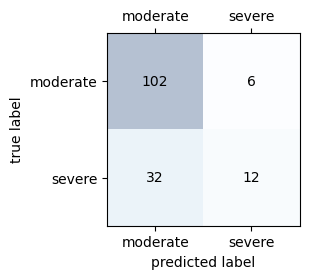

In [40]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
ax.set_xticks(np.arange(np.size(class_le.classes_)))
ax.set_xticklabels(class_le.classes_)
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
ax.set_yticks(np.arange(np.size(class_le.classes_)))
ax.set_yticklabels(class_le.classes_)
plt.show()

In [41]:
from sklearn.metrics import roc_curve, auc

In [42]:
from scipy import interp

In [43]:
probas = pipe_rf_fs_optHyp.predict_proba(X_test)

In [45]:
fpr, tpr, thresholds = roc_curve(y_test, probas[:,0], pos_label=0)

In [46]:
roc_auc = auc(fpr, tpr)

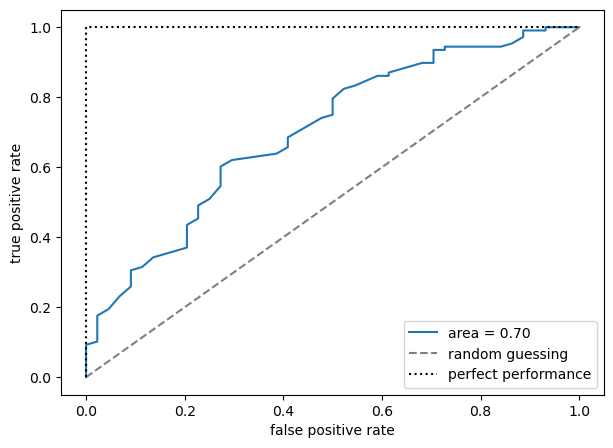

In [55]:
fig = plt.figure(figsize=(7, 5))
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = interp(mean_fpr, fpr, tpr)
plt.plot(fpr, tpr, label=f'area = {roc_auc:.2f}')
plt.plot([0, 1],[0, 1], ls='--', c='grey', label='random guessing')
plt.plot([0, 0, 1], [0, 1, 1], ls=':', c='black', label='perfect performance')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")
plt.show()